<a href="https://colab.research.google.com/github/giaminhh041223/Vehicle_detect/blob/main/Vehicle_detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Vui lòng chọn file data.zip từ máy tính của bạn...


Saving archive.zip to archive (1).zip
Ultralytics 8.3.231 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset/data_colab.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=car_detect_run2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=Tru

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


image 1/126 /content/dataset/Cars Detection/test/images/00dea1edf14f09ab_jpg.rf.3f17c8790a68659d03b1939a59ccda80.jpg: 640x640 1 Ambulance, 7.5ms
image 2/126 /content/dataset/Cars Detection/test/images/00dea1edf14f09ab_jpg.rf.KJ730oDTFPdXdJxvSLnX.jpg: 640x640 1 Ambulance, 7.9ms
image 3/126 /content/dataset/Cars Detection/test/images/00e481ea1a520175_jpg.rf.6e6a8b3b45c9a11d106958f88ff714ea.jpg: 640x640 3 Buss, 8.6ms
image 4/126 /content/dataset/Cars Detection/test/images/00e481ea1a520175_jpg.rf.MV6sZ8QCFwFeMYaI2tHm.jpg: 640x640 3 Buss, 9.3ms
image 5/126 /content/dataset/Cars Detection/test/images/08c8b73e0c2e296e_jpg.rf.7IkYAamjZhnwsoXSrwKt.jpg: 640x640 3 Buss, 7.9ms
image 6/126 /content/dataset/Cars Detection/test/images/08c8b73e0c2e296e_jpg.rf.effa65856584463c08848031cab357b9.jpg: 640x640 3 Buss, 7.9ms
image 7/126 /content/dataset/Cars Detection/test/images/10c26c6598677a1f_jpg.rf.USCbBYVcUICkLhuq07Lw.jpg: 640x640 1 Motorcycle, 7.5ms
image 8/126 /content/dataset/Cars Detection/test/im

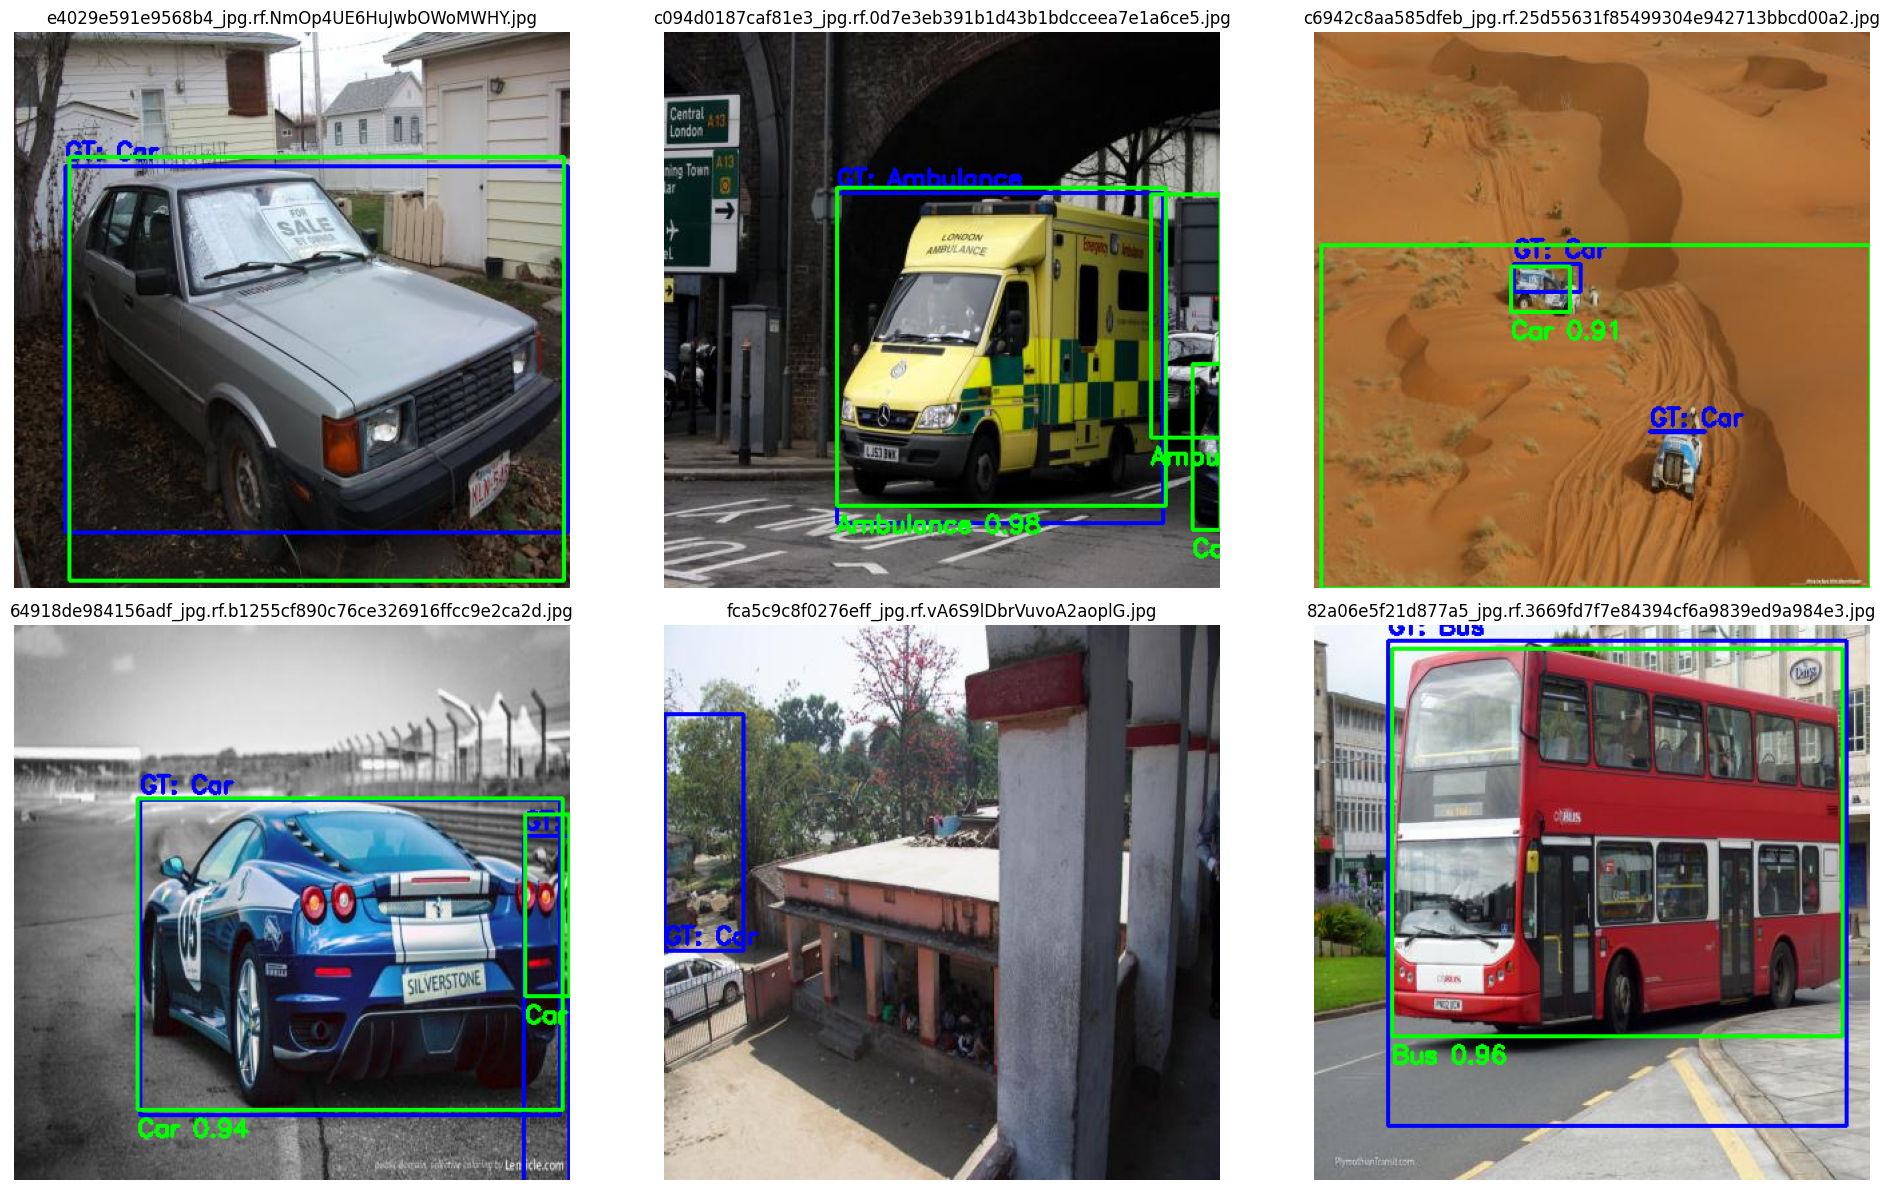

In [3]:
!pip install ultralytics

import os
import zipfile
import yaml
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import random
from google.colab import files

uploaded = files.upload()

zip_filename = next(iter(uploaded))
extract_path = '/content/dataset'

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

yaml_content = {
    'path': extract_path,
    'train': 'Cars Detection/train/images',
    'val': 'Cars Detection/valid/images',
    'test': 'Cars Detection/test/images',
    'names': {
        0: 'Ambulance',
        1: 'Bus',
        2: 'Car',
        3: 'Motorcycle',
        4: 'Truck'
    }
}

yaml_path = os.path.join(extract_path, 'data_colab.yaml')
with open(yaml_path, 'w') as f:
    yaml.dump(yaml_content, f, default_flow_style=False)

model = YOLO("yolo11n.pt")

results = model.train(
    data=yaml_path,
    epochs=50,
    imgsz=640,
    project='/content/runs',
    name='car_detect_run'
)

best_w = os.path.join('/content/runs', 'car_detect_run', 'weights', 'best.pt')
print(f"Đang tải file weights tốt nhất về máy: {best_w}")
files.download(best_w)

best_model = YOLO(best_w)

test_images_path = os.path.join(extract_path, "Cars Detection/test/images")
predict_results = best_model.predict(source=test_images_path, save=True, project='/content/runs_temp', name='predict')

class_names = ['Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck']
label_dir = os.path.join(extract_path, "Cars Detection/test/labels")

num_examples = 6
sample_results = random.sample(predict_results, min(num_examples, len(predict_results)))

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for i, result in enumerate(sample_results):
    if i >= num_examples: break

    image_path = result.path
    img = cv2.imread(image_path)
    if img is None: continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_combined = img.copy()

    label_filename = os.path.splitext(os.path.basename(image_path))[0] + '.txt'
    label_path = os.path.join(label_dir, label_filename)

    if os.path.exists(label_path):
        with open(label_path, 'r') as file:
            for line in file:
                parts = list(map(float, line.split()))
                cls_id = int(parts[0])
                x_center, y_center, width, height = parts[1:]
                h, w, _ = img.shape
                x1, y1 = int((x_center - width/2) * w), int((y_center - height/2) * h)
                x2, y2 = int((x_center + width/2) * w), int((x_center + height/2) * h)

                cv2.rectangle(img_combined, (x1, y1), (x2, y2), (0, 0, 255), 2)
                cv2.putText(img_combined, f"GT: {class_names[cls_id]}", (x1, y1 - 5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
        cls_id = int(box.cls.item())
        conf = box.conf.item()
        label = class_names[cls_id] if cls_id < len(class_names) else "Unknown"

        cv2.rectangle(img_combined, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img_combined, f"{label} {conf:.2f}", (x1, y2 + 20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    axes[i].imshow(img_combined)
    axes[i].axis('off')
    axes[i].set_title(os.path.basename(image_path))

plt.tight_layout()
plt.show()

--- Hãy chọng ảnh bất kỳ để test (jpg, png...) ---


Saving 0f7f3b82ff9db6e8_jpg.rf.77bd34603ccff62cac2773efbf128032.jpg to 0f7f3b82ff9db6e8_jpg.rf.77bd34603ccff62cac2773efbf128032.jpg

image 1/1 /content/0f7f3b82ff9db6e8_jpg.rf.77bd34603ccff62cac2773efbf128032.jpg: 640x640 1 Car, 13.0ms
Speed: 3.8ms preprocess, 13.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs_temp/predict2


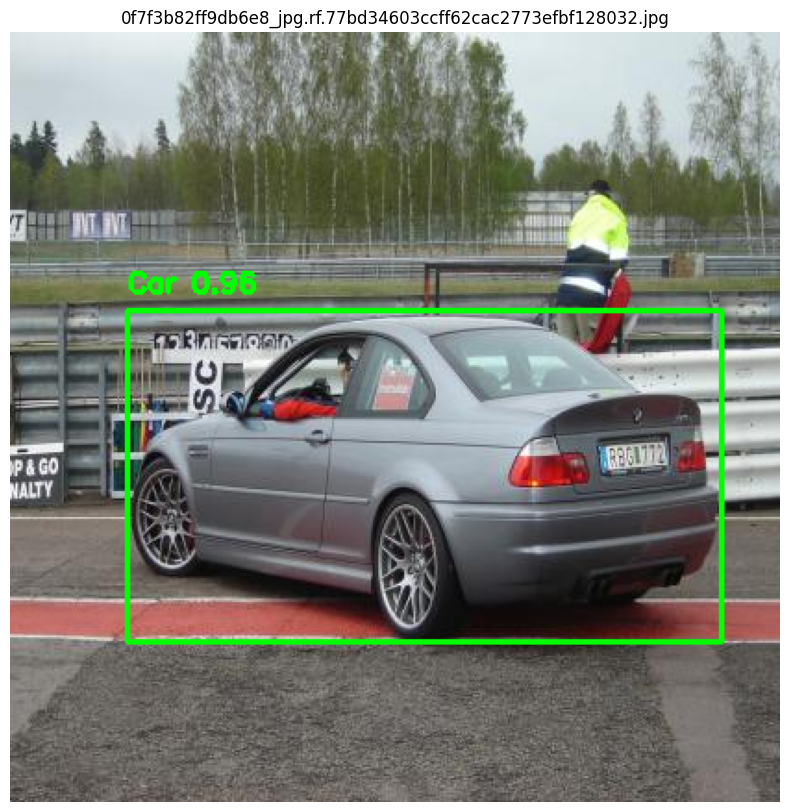

In [4]:
from google.colab import files
import cv2
import matplotlib.pyplot as plt

uploaded = files.upload()
filename = next(iter(uploaded))


results = best_model.predict(source=filename, conf=0.25, save=True)

img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

for result in results:
    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
        cls_id = int(box.cls.item())
        conf = box.conf.item()
        label = class_names[cls_id] if cls_id < len(class_names) else "Unknown"

        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img, f"{label} {conf:.2f}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.title(f"{filename}")
plt.show()